# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

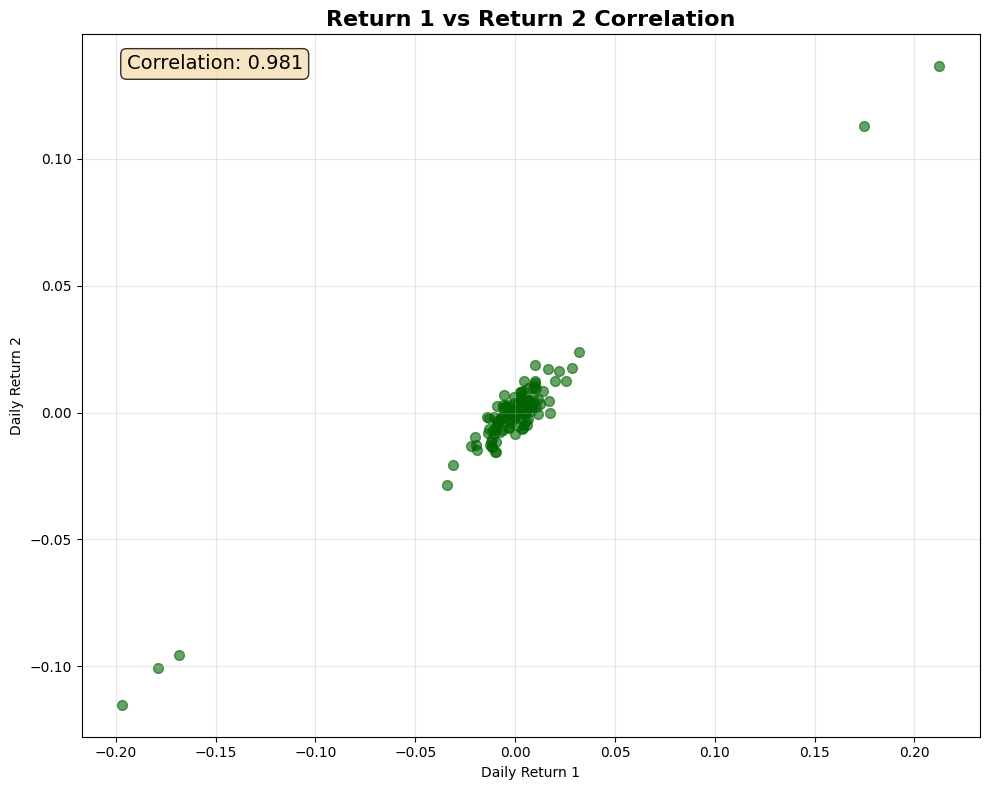

Scatter plot shows correlation between 115 data points
Correlation coefficient: 0.9807


In [14]:
plt.figure(figsize=(10, 8))

plt.scatter(df['daily_return'], df['daily_return_2'], alpha=0.6, s=50, color='darkgreen')
plt.title('Return 1 vs Return 2 Correlation', fontsize=16, fontweight='bold')
plt.xlabel('Daily Return 1')
plt.ylabel('Daily Return 2')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = df['daily_return'].corr(df['daily_return_2'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=14, 
         bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('../data/processed/scatter_plot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Scatter plot shows correlation between {len(df)} data points")
print(f"Correlation coefficient: {correlation:.4f}")


## Load Data (provided or synthetic fallback)

In [28]:
data_path = Path('../data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [29]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

*(Stretch)* Implement winsorizing (optional).

## Apply Detection and Create Flags (choose a numeric column)

In [30]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df.head()

,date,daily_return,daily_return_2,outlier_iqr,outlier_z
0,2022-01-03,0.001263,0.003834,False,False
1,2022-01-04,-0.020046,-0.009506,False,False
2,2022-01-05,0.004739,-0.000535,False,False
3,2022-01-06,0.009953,0.012539,False,False
4,2022-01-07,0.008872,0.009840,False,False


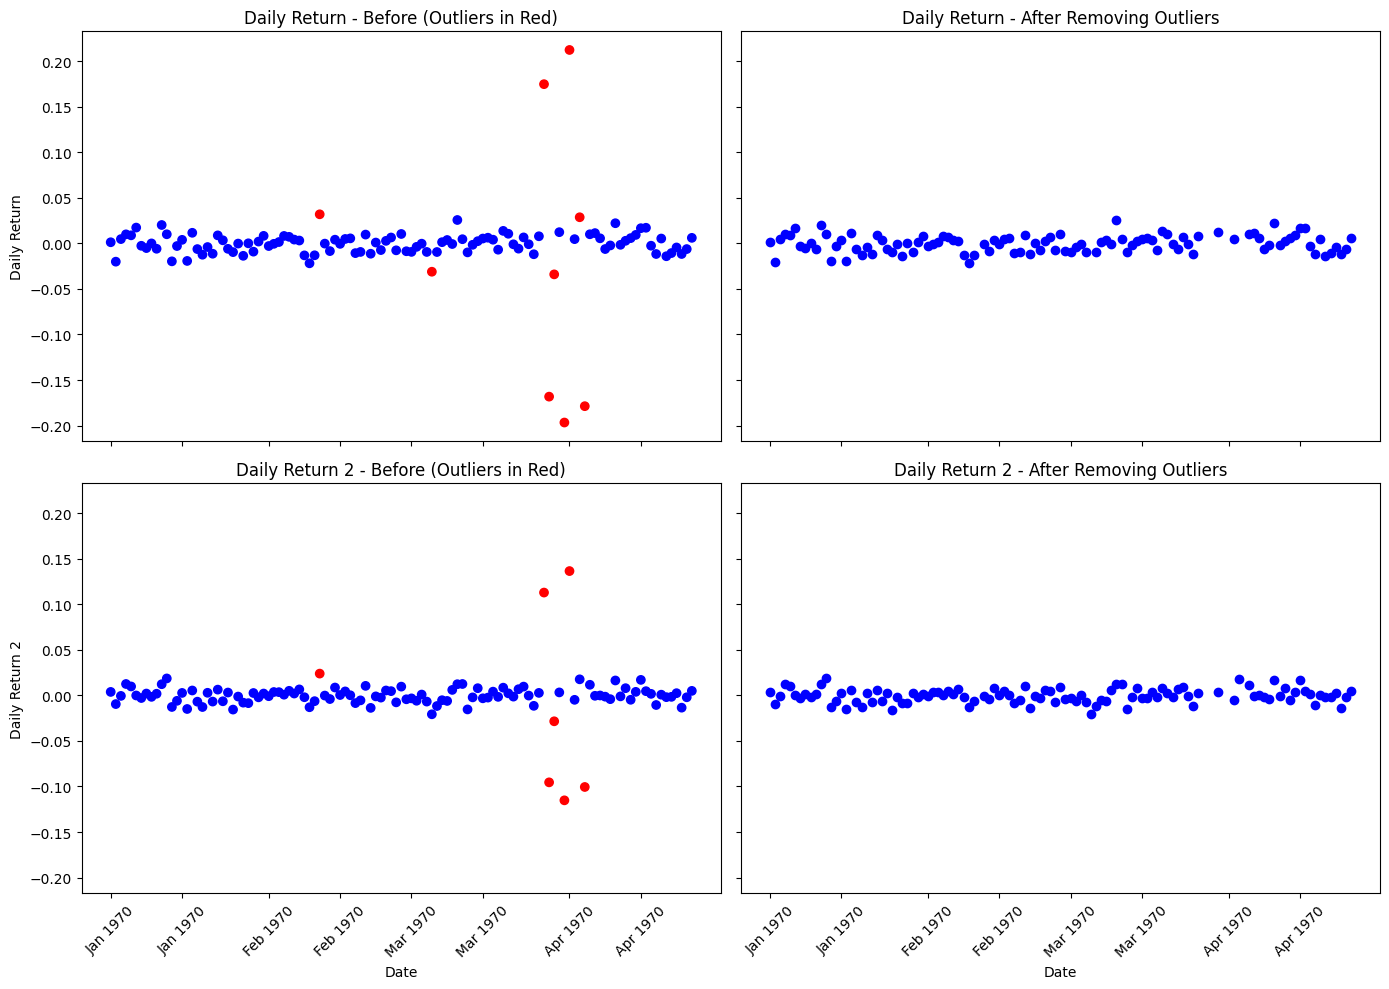

In [ ]:
import matplotlib.dates as mdates

mask1 = detect_outliers_iqr(df["daily_return"], k=1.5)
df_clean1 = df[~mask1]

mask2 = detect_outliers_iqr(df["daily_return_2"], k=1.5)
df_clean2 = df[~mask2]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

axes[0, 0].scatter(df["date"], df["daily_return"], c=mask1.map({True: "red", False: "blue"}))
axes[0, 0].set_title("Daily Return - Before (Outliers in Red)")
axes[0, 0].set_ylabel("Daily Return")

axes[0, 1].scatter(df_clean1["date"], df_clean1["daily_return"], c="blue")
axes[0, 1].set_title("Daily Return - After Removing Outliers")
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].scatter(df["date"], df["daily_return_2"], c=mask2.map({True: "red", False: "blue"}))
axes[1, 0].set_title("Daily Return 2 - Before (Outliers in Red)")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Daily Return 2")

axes[1, 1].scatter(df_clean2["date"], df_clean2["daily_return_2"], c="blue")
axes[1, 1].set_title("Daily Return 2 - After Removing Outliers")
axes[1, 1].set_xlabel("Date")
axes[1, 1].tick_params(axis='x', rotation=45)

for ax in axes.flatten():
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/daily_returns_outliers_before_after.png', dpi=300, bbox_inches='tight')
plt.show()


### Visual Checks (boxplot / histogram)

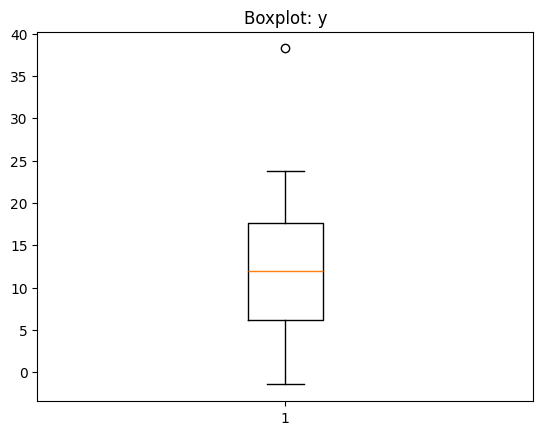

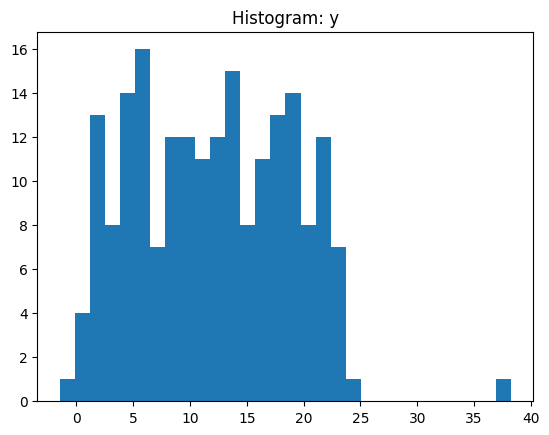

In [24]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [36]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001434,-0.000039,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.009443,0.010623


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

results_dict = {}

for col in ["daily_return", "daily_return_2"]:
    if "date" in df.columns: 
        X_all = df.index.to_numpy().reshape(-1, 1)
        y_all = df[col].to_numpy()

        mask = detect_outliers_iqr(df[col], k=1.5)
        X_filtered = df.loc[~mask].index.to_numpy().reshape(-1, 1)
        y_filtered = df.loc[~mask, col].to_numpy()

        model_all = LinearRegression().fit(X_all, y_all)
        model_flt = LinearRegression().fit(X_filtered, y_filtered)

        mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
        mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

        results_dict[col] = pd.DataFrame({
            'slope': [model_all.coef_[0], model_flt.coef_[0]],
            'intercept': [model_all.intercept_, model_flt.intercept_],
            'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
            'mae': [mae_all, mae_flt]
        }, index=['all', 'filtered_iqr'])
    else:
        print(f"Column {col}: No x values to regress on")

results = pd.concat(results_dict, axis=0)
print(results)


                                slope  intercept        r2       mae
daily_return   all          -0.000017  -0.000439  0.000206  0.016328
               filtered_iqr  0.000035  -0.001979  0.015813  0.007605
daily_return_2 all          -0.000009  -0.000138  0.000153  0.010964
               filtered_iqr  0.000020  -0.001226  0.007761  0.006023


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*

For both daily_return and daily_return_2, outliers were identified using the IQR method with a threshold of 1.5×IQR, a common choice to capture extreme deviations while retaining most typical observations. T

After filtering outliers, linear regression was performed to compare trends before and after removal. For daily_return, the slope changed from slightly negative (-0.000017) to positive (0.000035), and R² improved from 0.0002 to 0.0158, while MAE decreased from 0.0163 to 0.0076. Similarly, daily_return_2 showed improved fit and lower error after outlier removal. This demonstrates that outliers were skewing the regression line and inflating prediction errors, and removing them allowed the model to better capture the typical behavior of returns.